In [71]:
def fun_data_layout(v_data):
    print("Data 구조 : ", v_data.shape)
    print()
    
    print('변수 : ', v_data.columns)
    print()

In [72]:
import os
os.chdir("/home/piai/문서/2. Big Data 분석")
os.getcwd()
df_raw = pd.read_csv("./HMEQ.csv")

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from statsmodels.api import Logit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import pydotplus
import warnings
warnings.filterwarnings('ignore')

In [74]:
df_raw.head()

BAD  LOAN  MORTDUE     VALUE  ...       CLAGE NINQ  CLNO    DEBTINC
0    1  1700    30548   40320.0  ...  101.466002  1.0     8  37.113614
1    1  1800    28502   43034.0  ...   88.766030  0.0     8  36.884894
2    0  2300   102370  120953.0  ...   90.992533  0.0    13  31.588503
3    1  2400    34863   47471.0  ...   70.491080  1.0    21  38.263601
4    0  2400    98449  117195.0  ...   93.811775  0.0    13  29.681827

[5 rows x 13 columns]

In [75]:
fun_data_layout(df_raw)

Data 구조 :  (3748, 13)

변수 :  Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')



In [76]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [69]:
df_raw.BAD.value_counts(normalize=True)  #shift+tab

0    0.907951
1    0.092049
Name: BAD, dtype: float64

대부분은 0을 맞추는 데이터인데 우리는 1(즉 대출을 갚을지 안갚을지)가 더 중요하다!

=> 우리는 민감도보다는 특이도가 더 중요하다 (TP/(FP+TP)

In [77]:
df_raw['JOB'].unique()

array(['Other', 'Office', 'Mgr', 'ProfExe', 'Self', 'Sales', nan],
      dtype=object)

In [44]:
df_raw['JOB'].fillna('Other', inplace = True)
df_raw.fillna(df_raw.mean(), inplace=True)

In [45]:
df_train, df_test = train_test_split(df_raw, test_size=0.3, random_state=1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (2623, 13)
test data size : (1125, 13)


In [80]:
df_train['BAD'].value_counts(normalize=True), df_test['BAD'].value_counts(normalize=True)

(0    0.90812
 1    0.09188
 Name: BAD, dtype: float64,
 0    0.907556
 1    0.092444
 Name: BAD, dtype: float64)

train과 test의 비율이 비슷하다 => 랜덤하게 잘 뽑혔음을 확인할 수 있다.

In [85]:
help(logit)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [92]:
log_model = Logit.from_formula("BAD ~ LOAN+ MORTDUE+ VALUE+C(REASON) + C(JOB)+ YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC", df_train)
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.2257
Time:                        13:52:58   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

In [95]:
y_pred_train = log_result.predict(df_train)
y_pred_train_class = (y_pred_train>0.4).astype(int)
print("Train 예측결과 \n", y_pred_train_class.head(), '\n')
print("Confusion Matrix:\n{}".format(confusion_matrix(df_train['BAD'], y_pred_train_class)),'\n')


Train 예측결과 
 3164    0
3314    1
93      0
1456    0
3327    0
dtype: int64 

Confusion Matrix:
[[2352   30]
 [ 173   68]] 



In [108]:
y_pred_test = log_result.predict(df_test)
y_pred_test_class = (y_pred_test>0.4).astype(int)
print("Test 예측결과 \n", y_pred_test_class.head(), '\n')
print("Confusion Matrix:\n{}".format(confusion_matrix(df_test['BAD'], y_pred_test_class)),'\n')


Test 예측결과 
 1721    0
822     0
1686    0
789     0
165     0
dtype: int64 

Confusion Matrix:
[[1012    9]
 [  79   25]] 



In [113]:
print('Trian 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train['BAD'], y_pred_train_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['BAD'], y_pred_train_class)),'\n')
print(classification_report(df_train['BAD'], y_pred_train_class,target_names = ['승인', '거절'] ,digits=3))

Trian 예측/분류 결과
Accuracy: 0.923

Confusion Matrix:
[[2352   30]
 [ 173   68]] 

              precision    recall  f1-score   support

          승인      0.931     0.987     0.959      2382
          거절      0.694     0.282     0.401       241

    accuracy                          0.923      2623
   macro avg      0.813     0.635     0.680      2623
weighted avg      0.910     0.923     0.907      2623



In [114]:
print('Test 예측/분류 결과')
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test['BAD'], y_pred_test_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test['BAD'], y_pred_test_class)),'\n')
print(classification_report(df_test['BAD'], y_pred_test_class,target_names = ['승인', '거절'], digits=3))

Test 예측/분류 결과
Accuracy: 0.922

Confusion Matrix:
[[1012    9]
 [  79   25]] 

              precision    recall  f1-score   support

          승인      0.928     0.991     0.958      1021
          거절      0.735     0.240     0.362       104

    accuracy                          0.922      1125
   macro avg      0.831     0.616     0.660      1125
weighted avg      0.910     0.922     0.903      1125



<Axes: >

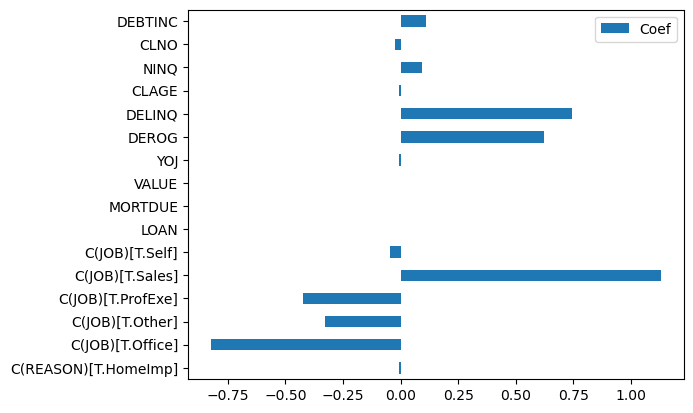

In [115]:
df_logistic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef')

In [104]:
df_char = df_raw.select_dtypes(include = 'object')
df_numeric = df_raw.select_dtypes(exclude = 'object')

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis = 1)
df_scaled.head()

BAD      LOAN   MORTDUE     VALUE  ...      CLNO   DEBTINC   REASON     JOB
0  3.140664 -1.559587 -0.993626 -1.222620  ... -1.428350  0.356347  HomeImp   Other
1  3.140664 -1.550817 -1.039240 -1.172701  ... -1.428350  0.329025  HomeImp   Other
2 -0.318404 -1.506968  0.607570  0.260485  ... -0.905133 -0.303684  HomeImp  Office
3  3.140664 -1.498198 -0.897428 -1.091090  ... -0.067985  0.493725  HomeImp     Mgr
4 -0.318404 -1.498198  0.520156  0.191363  ... -0.905133 -0.531456  HomeImp  Office

[5 rows x 13 columns]

In [63]:
df_scaled['BAD'] = np.where(df_scaled['BAD']>0, 1, 0)
df_scaled.head()

BAD      LOAN   MORTDUE     VALUE  ...      CLNO   DEBTINC   REASON     JOB
0    1 -1.559587 -0.993626 -1.224910  ... -1.428350  0.356347  HomeImp   Other
1    1 -1.550817 -1.039240 -1.174897  ... -1.428350  0.329025  HomeImp   Other
2    0 -1.506968  0.607570  0.260973  ... -0.905133 -0.303684  HomeImp  Office
3    1 -1.498198 -0.897428 -1.093133  ... -0.067985  0.493725  HomeImp     Mgr
4    0 -1.498198  0.520156  0.191721  ... -0.905133 -0.531456  HomeImp  Office

[5 rows x 13 columns]

In [64]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size=0.3, random_state=1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (2623, 13)
test data size : (1125, 13)


In [66]:
scaled_log_model = Logit.from_formula("BAD ~ LOAN+ MORTDUE+ VALUE+C(REASON) + C(JOB)+ YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC", df_scaled_train)
scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.2257
Time:                        11:48:39   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

<Axes: >

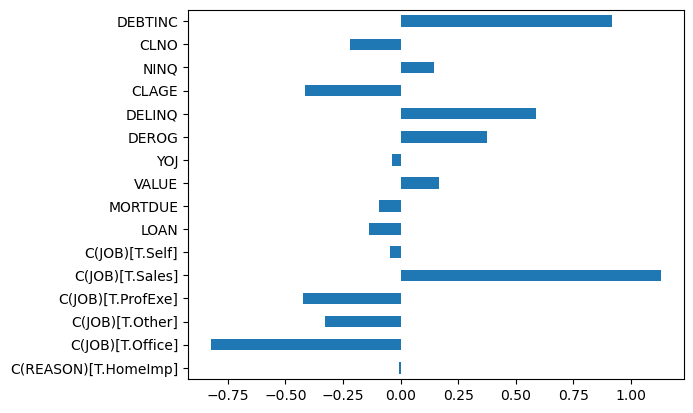

In [68]:
df_log_scaled_coef = pd.DataFrame({'Coef':log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = 'Coef', legend = False)